In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings

# standard libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sb
import pandas as pd

# modules from particles
import particles  # core module
from particles import distributions as dists  # where probability distributions are defined
from particles import state_space_models as ssm  # where state-space models are defined

In [3]:
raw_data = pd.read_csv('./data.csv', names=["Jul.Day","YYYY/MM/DD","Wdy","EUR/USD","GBP/USD"])

In [4]:
data = raw_data[["EUR/USD","GBP/USD"]].values

In [46]:
data.shape

AttributeError: 'list' object has no attribute 'shape'

In [7]:
# class StochVol(ssm.StateSpaceModel):
#     def PX0(self):  # Distribution of X_0
#         return dists.Normal(loc=self.mu, scale=self.sigma / np.sqrt(1. - self.rho**2))
#     def PX(self, t, xp):  # Distribution of X_t given X_{t-1}=xp (p=past)
#         return dists.Normal(loc=self.mu + self.rho * (xp - self.mu), scale=self.sigma)
#     def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
#         return dists.Normal(loc=0., scale=np.exp(x))

In [8]:
# class MVStochVol(StateSpaceModel):
#     """Multivariate stochastic volatility model. 

#     X_0 ~ N(mu,covX)
#     X_t-mu = F*(X_{t-1}-mu)+U_t   U_t~N(0,covX)
#     Y_t(k) = exp(X_t(k)/2)*V_t(k) for k=1,...,d
#     V_t ~ N(0,corY)
#     """
#     default_params = {'mu': 0., 'covX': None, 'corY': None, 'F': None}  # TODO

#     def offset(self):
#         return self.mu - np.dot(self.F, mu)

#     def PX0(self):
#         return dists.MvNormal(loc=self.mu, cov=self.corX)

#     def PX(self, t, xp):
#         return dists.MvNormal(loc=np.dot(xp, self.F.T) + self.offset(),
#                               cov=self.covX)

#     def PY(self, t, xp, x):
#         return dists.MvNormal(scale=np.exp(0.5 * x), cov=self.corY)


In [14]:
np.diag(np.array([1,2,3]))

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

In [68]:
class Basic_MVStochVol(ssm.StateSpaceModel):
    """
    Parameters:
    self.mu \in R^p
    self.phi \in R^p
    self.cov_ita \in R^{pxp}
    self.cov_eps \in R^{pxp}
    """
    def offset(self):
        return self.mu - np.dot(np.diag(self.phi), self.mu)

    def PX0(self):
        cov_X0 = np.zeros_like(self.cov_ita)
        p = len(self.mu)
        for i in range(p):
            for j in range(p):
                cov_X0[i, j] = self.cov_ita[i,j]/(1 - self.phi[i]*self.phi[j])
        return dists.MvNormal(loc=self.mu, cov=cov_X0)
    
    def PX(self, t, xp):
        return dists.MvNormal(loc=np.dot(xp, np.diag(self.phi).T) + self.offset(), cov=self.cov_ita)
    
    def PY(self, t, xp, x):
        return dists.MvNormal(loc=0., scale=np.exp(0.5 * x), cov=self.cov_eps)

In [87]:
cov_ita = np.array([[0.2,0.3],[0.1, 0.15]])
cov_eps = np.array([[0.25,0.35],[0.1, 0.15]])
my_model = Basic_MVStochVol(mu=np.array([0,0]), phi=np.array([.9, 0.8]), cov_ita=cov_ita, cov_eps=cov_eps)
true_states, observed_data = my_model.simulate(1000)  # we simulate from the model 100 data points

In [88]:
observed = np.concatenate(observed_data)

state = np.concatenate(true_states)

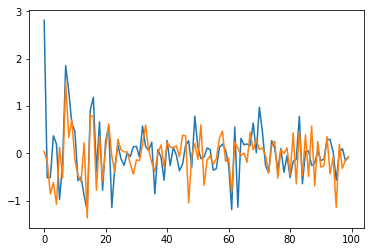

In [76]:
plt.plot(tmp)

In [91]:
fk_model = ssm.Bootstrap(ssm=my_model, data=observed)  # we use the Bootstrap filter
pf = particles.SMC(fk=fk_model, N=200, resampling='stratified', moments=True, store_history=True)  # the algorithm
pf.run()  # actual computation

Text(0.5, 1.0, 'True state')

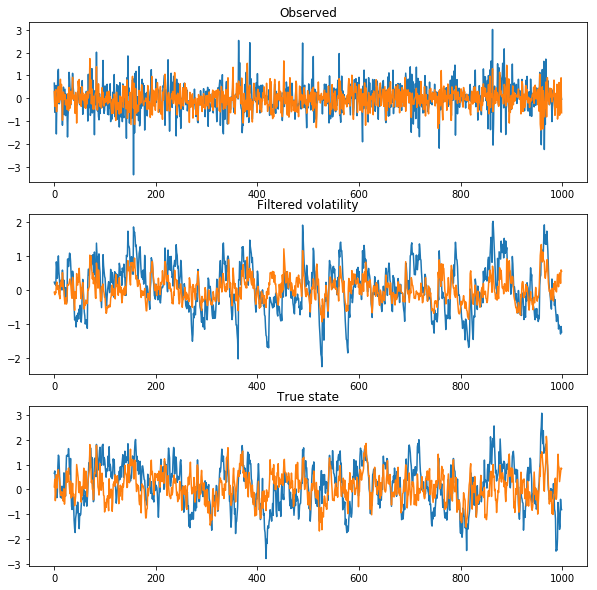

In [92]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(observed)
plt.title('Observed')
plt.subplot(3,1,2)
plt.plot([m['mean'] for m in pf.summaries.moments])
plt.title('Filtered volatility')
plt.subplot(3,1,3)
plt.plot(state)
plt.title('True state')